# Name: Nalet Meinen

In [ ]:
%matplotlib inline
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import os
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np

from tqdm.notebook import tqdm
from IPython.display import clear_output

# Define which device to use for computations
# If you have gpu, use 'cuda'
device = torch.device('cuda')
#device = torch.device('cpu')

# Assignment 1 ATML 2021

In [ ]:
!nvidia-smi
if not os.path.isfile('dataset.py'):
    from google.colab import drive
    drive.mount('/content/drive')
    !cp -r "/content/drive/My Drive/ATML/Assignments/Assignment1/dataset.py" "dataset.py"

Sun Mar 28 16:25:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Task 1. Prepare data for training and model selection

PyTorch torchvision module provides you with some predesigned datasets. Like the MNIST dataset, that we are going to use (https://pytorch.org/vision/0.8/_modules/torchvision/datasets/mnist.html#MNIST). Let us build a simple MNIST dataset and visualise some samples.

60000
5


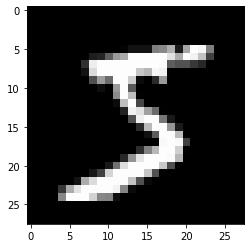

In [ ]:
mnist_dataset = torchvision.datasets.MNIST(root=".", train=True, download=True)
print(len(mnist_dataset))
image, label = mnist_dataset[0]
plt.imshow(image, cmap='gray')
print(label)

For the needs of this assignment you will have to implement a similar Dataset class which will yield an image pair and a label equal to the mode 10 sum of the labels in the pair. 

### MnistPairs dataset

Implement the __getitem__ method in the dataset.py file. Build training and test sets with the 'right' and 'left' orders of the digits. Split the both training sets into training and validation sets with 90% and 10% of the data respectively. Concatenate the validation sets into one with both 'right' and 'test' orders. The same should be done with the test sets. Visualise some samples from the constructed datasets.

In [ ]:
from dataset import MnistPairs

Length of dataset: 30000


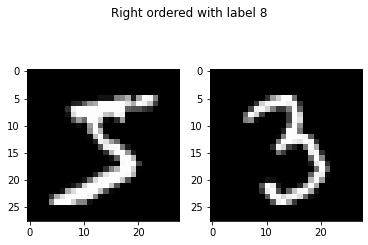

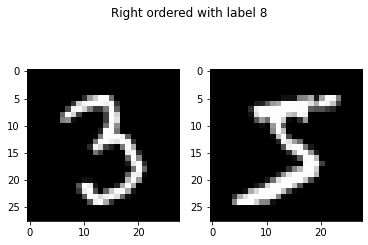

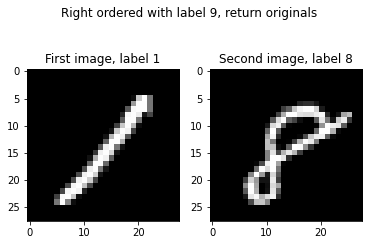

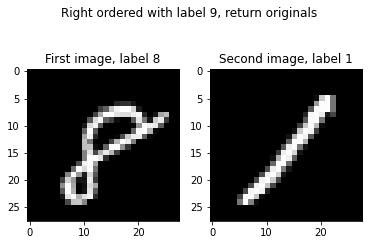

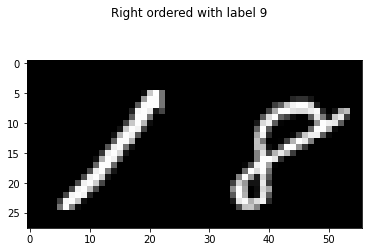

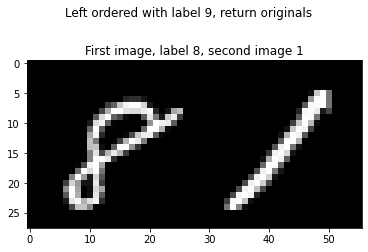

In [ ]:
dataset = MnistPairs(root=".", train=True, download=True, order='right')
print("Length of dataset:",len(dataset))
item = dataset[0]
plt.subplot(1,2,1), plt.imshow(item[0], cmap='gray')
plt.subplot(1,2,2), plt.imshow(item[1], cmap='gray')
plt.suptitle("Right ordered with label {}".format(item[2]))
plt.show()

dataset = MnistPairs(root=".", train=True, download=True, order='left')
item = dataset[0]
plt.subplot(1,2,1), plt.imshow(item[0], cmap='gray')
plt.subplot(1,2,2), plt.imshow(item[1], cmap='gray')
plt.suptitle("Right ordered with label {}".format(item[2]))
plt.show()

dataset = MnistPairs(root=".", train=True, download=True, order='right', return_original_labels=True)
item = dataset[len(dataset)-1] # test last item
plt.subplot(1,2,1), plt.imshow(item[0], cmap='gray')
plt.title("First image, label {}".format(item[3]))
plt.subplot(1,2,2), plt.imshow(item[1], cmap='gray')
plt.title("Second image, label {}".format(item[4]))
plt.suptitle("Right ordered with label {}, return originals".format(item[2]))
plt.show()

dataset = MnistPairs(root=".", train=True, download=True, order='left', return_original_labels=True)
item = dataset[len(dataset)-1] # test last item
plt.subplot(1,2,1), plt.imshow(item[0], cmap='gray')
plt.title("First image, label {}".format(item[3]))
plt.subplot(1,2,2), plt.imshow(item[1], cmap='gray')
plt.title("Second image, label {}".format(item[4]))
plt.suptitle("Right ordered with label {}, return originals".format(item[2]))
plt.show()

dataset = MnistPairs(root=".", train=True, download=True, order='right', return_original_labels=True, concatenated=True)
item = dataset[len(dataset)-1] # test last item
plt.imshow(item[0], cmap='gray')
plt.suptitle("Right ordered with label {}".format(item[1]))
plt.show()

dataset = MnistPairs(root=".", train=True, download=True, order='left', return_original_labels=True, concatenated=True)
item = dataset[len(dataset)-1] # test last item
plt.imshow(item[0], cmap='gray')
plt.title("First image, label {}, second image {}".format(item[2], item[3]))
plt.suptitle("Left ordered with label {}, return originals".format(item[1]))
plt.show()

In [ ]:
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                             torchvision.transforms.Normalize(mean=(0.5,), std=(0.5,))])

dataset_left = MnistPairs(root=".", train=True, download=True, transform=transforms, order='left', return_original_labels=True, concatenated=True)
dataset_left_test_set = MnistPairs(root=".", train=False, download=True, transform=transforms, order='left', return_original_labels=True, concatenated=True)
dataset_left_train_set, dataset_left_val_set = torch.utils.data.random_split(dataset_left, [27000, 3000])
#Right
dataset_right = MnistPairs(root=".", train=True, download=True, transform=transforms, order='right', return_original_labels=True, concatenated=True)
dataset_right_test_set = MnistPairs(root=".", train=False, download=True, transform=transforms, order='right', return_original_labels=True, concatenated=True)
dataset_right_train_set, dataset_right_val_set = torch.utils.data.random_split(dataset_right, [27000, 3000])
#Both
dataset_both_train_set = torch.utils.data.ConcatDataset([dataset_left_train_set, dataset_right_train_set])
dataset_both_test_set = torch.utils.data.ConcatDataset([dataset_left_test_set, dataset_right_test_set])
dataset_both_val_set = torch.utils.data.ConcatDataset([dataset_left_val_set, dataset_right_val_set])

print("Length of concatenated train is {}, length of concatenated test is {}, length of concatenated val is {}.".format(len(dataset_both_train_set), len(dataset_both_test_set), len(dataset_both_val_set)))

Length of concatenated train is 54000, length of concatenated test is 10000, length of concatenated val is 6000.


### Label and Pair Distribution

Visualize the distribution of the labels and pairs in the training, validation and testing sets.

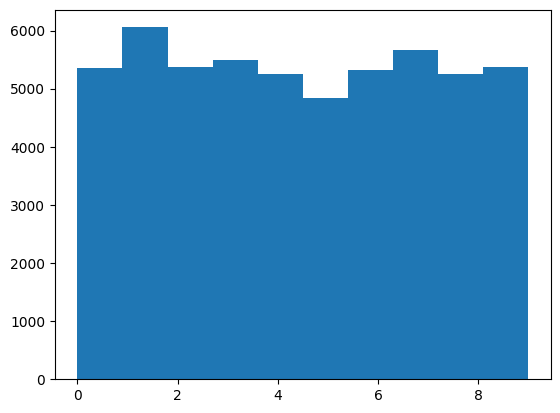

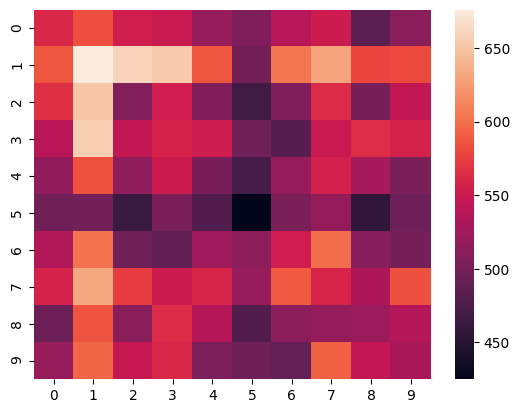

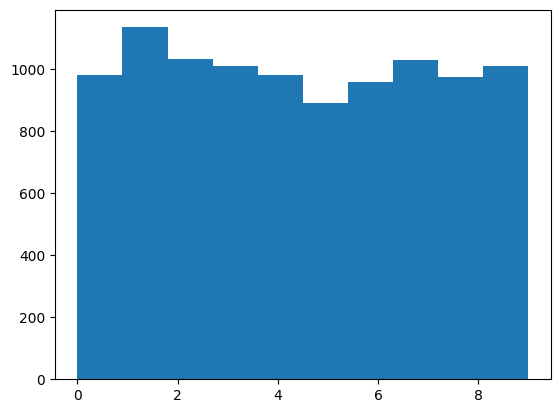

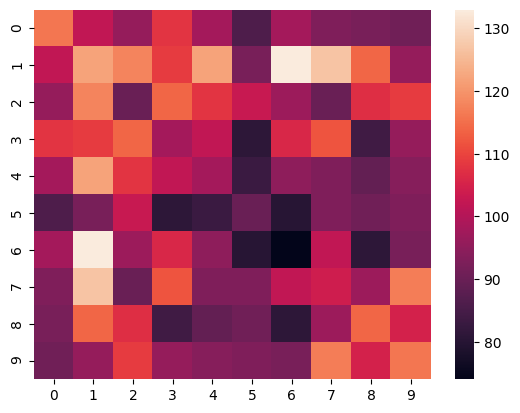

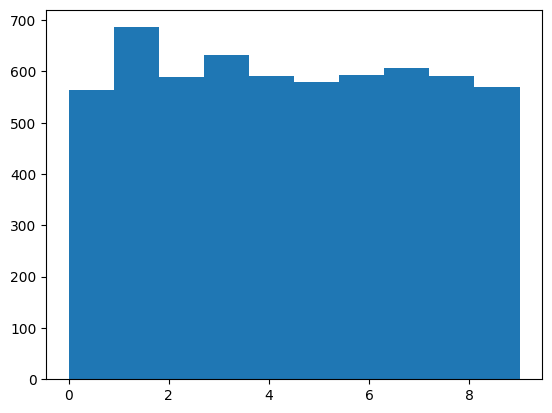

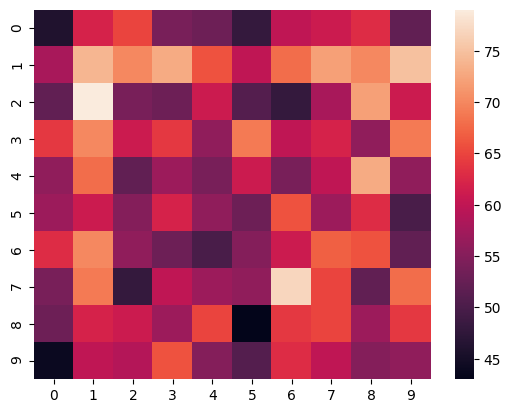

In [ ]:
import seaborn as sns; sns.set_theme()

def calculate_distribution_of_labels(dataset):
    hist = []
    pairs = np.zeros((10,10))
    for item in dataset:
        hist.append(item[2])
        pairs[item[2], item[3]] += 1
    plt.rcdefaults()
    plt.hist(hist)
    plt.show()

    sns.heatmap(pairs)
    plt.show()
    plt.rcdefaults()

calculate_distribution_of_labels(dataset_both_train_set)
calculate_distribution_of_labels(dataset_both_test_set)
calculate_distribution_of_labels(dataset_both_val_set)


If the distribution of the labels in the test set differs from the one in the training set, we should expect a different performance of the model on the test set.

## Task 2. Design training settings

Having the MnistPairs dataset implemented, we can now nicely wrap in with a DataLoader class for the ease of training.

In [ ]:
batch_size=128
#Left
train_left_loader = torch.utils.data.DataLoader(dataset_left_train_set, batch_size=batch_size, shuffle=True)
val_left_loader = torch.utils.data.DataLoader(dataset_left_val_set, batch_size=batch_size, shuffle=False)
test_left_loader = torch.utils.data.DataLoader(dataset_left_test_set, batch_size=batch_size, shuffle=False)
#Right
train_right_loader = torch.utils.data.DataLoader(dataset_right_train_set, batch_size=batch_size, shuffle=True)
val_right_loader = torch.utils.data.DataLoader(dataset_right_val_set, batch_size=batch_size, shuffle=False)
test_right_loader = torch.utils.data.DataLoader(dataset_right_test_set, batch_size=batch_size, shuffle=False)
#Both
train_both_loader = torch.utils.data.DataLoader(dataset_both_train_set, batch_size=batch_size, shuffle=True)
val_both_loader = torch.utils.data.DataLoader(dataset_both_val_set, batch_size=batch_size, shuffle=False)
test_both_loader = torch.utils.data.DataLoader(dataset_both_test_set, batch_size=batch_size, shuffle=False)

Define a bunch of models to test, the loss function and the optimizers.

In [ ]:
class Module4Model(torch.nn.Module):
    def __init__(self):
        super(Module4Model, self).__init__()
        self.main = nn.Sequential(nn.ReLU(),
                                  nn.Linear(56*28, 256),
                                  nn.ReLU(),
                                  nn.Linear(256, 128),
                                  nn.ReLU(),
                                  nn.Linear(128, 10),
                                  nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        out = x.view(x.size(0), 56*28)
        out = self.main(out)
        return out

model = Module4Model()
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

Let us also define the metric we are going to use for the assesment of the model. We will simply use the accuracy of the model.

In [ ]:
def accuracy(labels, predictions):
    # Return the accuracy of predictions, i.e. the part of cases
    # where the corresponding prediction matches the label.
    pass

Write the training loop.

In [ ]:
def train(model, dataloader, optimizer, loss_fn):
    model.train()
    for iteration, (images, labels, _, _) in enumerate((dataloader)):
        ## TODO: fill the training loop
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
        # The code below will print loss every 100 iterations. Make sure the loss computer by loss_fn is in variable "loss"
        #if iteration % 100 == 0:
        #print('Training iteration {}: loss {:.4f}'.format(iteration, loss.item()))

def train_model(model, dataloader, val_dataloader, optimizer, num_epochs, loss_fn):
    for epoch in range(num_epochs):
        train(model, dataloader, optimizer, loss_fn)
        print('Epoch {}'.format(epoch+1))
        print('Validation:\t',end=''), evaluate_model(model, val_dataloader)
        print('Train:\t\t',end=''), evaluate_model(model, dataloader)

Write the evaluation code.

In [ ]:
def evaluate_model(model, dataset_loader):
    model.eval()
    # TODO - initialize any variables if necessary
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for images, labels, _, _ in dataset_loader:
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            loss = loss_fn(output, labels)
            predicted_labels = output.argmax(dim=1)
            correct_predictions += (predicted_labels == labels).sum().item()
            losses.append(loss.item())

    ## Store and print average test loss and accuracy
    average_loss = sum(losses) / len(losses)
    accuracy = correct_predictions / len(dataset_loader)
    print('Test average loss: {:.4f}, accuracy: {:.3f}'.format(average_loss, accuracy))

## Task 3. Train on training 'right' set.

Train the models on training 'right' set and select the best model on the validation set.

In [ ]:
train_model(model, train_right_loader, val_right_loader, optimizer, 50, loss_fn)
evaluate_model(model, test_right_loader)

Epoch 1
Validation:	Test average loss: 2.3004, accuracy: 14.792
Train:		Test average loss: 2.2993, accuracy: 16.118
Epoch 2
Validation:	Test average loss: 2.2978, accuracy: 15.667
Train:		Test average loss: 2.2952, accuracy: 17.768
Epoch 3
Validation:	Test average loss: 2.2931, accuracy: 19.000
Train:		Test average loss: 2.2888, accuracy: 22.915
Epoch 4
Validation:	Test average loss: 2.2851, accuracy: 20.667
Train:		Test average loss: 2.2779, accuracy: 25.308
Epoch 5
Validation:	Test average loss: 2.2670, accuracy: 23.542
Train:		Test average loss: 2.2566, accuracy: 29.801
Epoch 6
Validation:	Test average loss: 2.2274, accuracy: 28.875
Train:		Test average loss: 2.2121, accuracy: 34.294
Epoch 7
Validation:	Test average loss: 2.1328, accuracy: 35.167
Train:		Test average loss: 2.1040, accuracy: 40.758
Epoch 8
Validation:	Test average loss: 1.9604, accuracy: 41.833
Train:		Test average loss: 1.9134, accuracy: 48.246
Epoch 9
Validation:	Test average loss: 1.7979, accuracy: 48.292
Train:		

## Task 4. Train on concatenated training set.

Train the models on concatenated training set and select the best model on the validation set.

##  Task 5. Evaluation

From the previously selected models select the one that shows the best results on the validation set. Let's denote this as the best model. How can you explain the differences in the accuracies of the models trained on different training sets?


Report the accuracy of the best model on the test set.

## Task 6. Visualizations

Visualize some examples of the best model's successful and failure predictions on the test set. Visualize the accuaracy depending on the digit pairs. Why is the model better or worse on some digits? 

In [ ]:
!cp 'dataset.py' '/content/drive/My Drive/ATML/Assignments/Assignment1/'